### Install libraries

In [ ]:
!pip install -r /content/dev-requirements.txt

### Set up variables for MLFlow

In [ ]:
# Load .env file if it exists
# Don't use dotenv
!pip install python-dotenv

from dotenv import load_dotenv
load_dotenv('../.env')

### Load Data

In [ ]:
import pandas as pd
import os

folder = os.path.join("../airflow/assets")
dfs = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        dfs.append(pd.read_csv(os.path.join(folder, file), skiprows=1, parse_dates=['date']))
print(dfs.__len__())

#### Merge all data into one dataframe

In [ ]:
import pandas as pd

# Step 1: Convert "date" column to datetime in all dataframes
for df in dfs:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors="coerce")

# Step 2: Find the oldest and newest dates across all dataframes
all_dates = [df['date'] for df in dfs]
all_dates_flat = [date for sublist in all_dates for date in sublist if not pd.isnull(date)]

oldest_date = min(all_dates_flat)
newest_date = max(all_dates_flat)

# Step 3: Create a new dataframe with the date range
date_range = pd.date_range(start=oldest_date, end=newest_date, freq='H')  # Hourly frequency
merged_df = pd.DataFrame({'date': date_range})

# Step 4: Add "close" columns from each dataframe to the merged_df using list comprehension
for df in dfs:
    try:
        ticker = df['symbol'].iloc[0]  # Assuming each dataframe has a "ticker" column
        close_col_name = f'close_{ticker}'

        df = df.set_index('date').sort_index()
        df = df[~df.index.duplicated(keep='first')].reindex(date_range, method='ffill')

        # Create a DataFrame with the "date" and "close" columns
        close_data = df[df.index.isin(date_range)][['close']]
        close_data.rename(columns={'close': close_col_name}, inplace=True)

        # Merge the "close_data" into the "merged_df"
        merged_df = pd.merge(merged_df, close_data, left_on='date', right_index=True, how='left')
    except ValueError as e:
        print(f'Error on coin {ticker}: {e}')


# Now, merged_df contains the desired data with the date range and "close_{ticker}" columns, with missing hours filled.


### Clustering Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from fastdtw import fastdtw
from tqdm import tqdm
import mlflow
import mlflow.sklearn
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids

def do_clustering(
    time_series_data,
    distances=None,
    experiment_name_suffix="",
    cluster_range=range(2,8),
    clustering_algorithm="KMeans"
):

    experiment_name = f"Clustering_{clustering_algorithm}_{experiment_name_suffix}"

    # Create MLflow experiment
    mlflow.set_experiment(experiment_name)

    if distances is None:
      # Initialize an empty array to store the distances
      distances = np.zeros((time_series_data.shape[0], time_series_data.shape[0]))
      # Calculate DTW distances between time series columns with progress tracking
      for i in tqdm(range(time_series_data.shape[0]), desc="Calculating DTW Distances"):
        for j in range(i, time_series_data.shape[0]):
            distance, _ = fastdtw(time_series_data[i], time_series_data[j])
            distances[i, j] = distance
            distances[j, i] = distance

      print("DTW distances calculated.")

    # Silhouette Score vs. Cluster Count
    silhouette_scores = []
    inertia_scores = []

    # Iterate through different cluster counts
    for n_clusters in cluster_range:
        # Create a unique experiment name for each cluster count
        run_name = f"{experiment_name}_{n_clusters}_Clusters"

        with mlflow.start_run(run_name=run_name):
            print(f"Running experiment for {n_clusters} clusters...")

            if clustering_algorithm == "KMeans":
                # Perform K-Means clustering with DTW distances
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(distances)

                # Get cluster labels
                labels = kmeans.labels_
                inertia_score = kmeans.inertia_

                print("K-Means clustering completed.")

            elif clustering_algorithm == "KMedoids":
                # Perform K-Medoids clustering with DTW distances
                kmedoids = KMedoids(n_clusters=n_clusters, metric="precomputed", random_state=0).fit(distances)

                # Get cluster labels
                labels = kmedoids.labels_
                inertia_score = kmedoids.inertia_

                print("K-Medoids clustering completed.")

            # Log clustering results and distances to MLflow
            mlflow.log_param("Cluster_Count", n_clusters)
            mlflow.log_param("Distance_Matrix_Shape", distances.shape)
            mlflow.log_param("Cluster_Labels", labels.tolist())

            print("Clustering results logged to MLflow.")

            # Calculate Silhouette Score and Inertia
            silhouette = silhouette_score(distances, labels, metric="precomputed")

            silhouette_scores.append(silhouette)
            inertia_scores.append(inertia_score)

            mlflow.log_metric("Silhouette_Score", silhouette)
            mlflow.log_metric("Inertia_Score", inertia_score)

            print(f"Silhouette Score: {silhouette}")
            print(f"Inertia Score: {inertia_score}")

            # Define a color palette for plotting
            palette = sns.color_palette("husl", len(time_series_data))

            # Visualize the clustered time series using Seaborn
            num_rows = n_clusters
            num_cols = 1
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

            for cluster_id in range(n_clusters):
                ax = axes[cluster_id] if num_rows > 1 else axes
                for series_idx, label in enumerate(labels):
                    if label == cluster_id:
                        series_name = merged_df.columns[series_idx + 1]  # Get the column name (series name)
                        sns.lineplot(data=time_series_data[series_idx], color=palette[series_idx], label=series_name, ax=ax)

                ax.annotate(f"Inertia: {inertia_score:.2f}", xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
                ax.annotate(f"Silhouette: {silhouette:.2f}", xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)

                ax.set_title(f"Cluster {cluster_id + 1}")
                ax.legend(loc='upper right')  # Add legends for series in the cluster

            plt.tight_layout()

            # Save the plot to a file and log it to MLflow
            plot_path = f"cluster_plots_{n_clusters}_clusters.png"
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path)

            print("Cluster visualization plot saved and logged to MLflow.")

            plt.show()

    with mlflow.start_run(run_name="Scores_logging"):
      # Log the lists of Silhouette and Inertia scores
      mlflow.log_param("Silhouette_Scores", silhouette_scores)
      mlflow.log_param("Inertia_Scores", inertia_scores)

      # Silhouette Score vs. Cluster Count plot
      plt.figure(figsize=(8, 4))
      plt.plot(cluster_range, silhouette_scores, marker='o')
      plt.title("Silhouette Score vs. Cluster Count")
      plt.xlabel("Cluster Count")
      plt.ylabel("Silhouette Score")
      plt.tight_layout()
      plt.savefig("silhouette_scores_plot.png")
      mlflow.log_artifact("silhouette_scores_plot.png")

      # Inertia Score vs. Cluster Count plot
      plt.figure(figsize=(8, 4))
      plt.plot(cluster_range, inertia_scores, marker='o')
      plt.title("Inertia Score vs. Cluster Count")
      plt.xlabel("Cluster Count")
      plt.ylabel("Inertia Score")
      plt.tight_layout()
      plt.savefig("inertia_scores_plot.png")
      mlflow.log_artifact("inertia_scores_plot.png")

#### Clustering Analysis (on Raw Series)

In [ ]:
# Select the time series columns for clustering
time_series_data = merged_df.iloc[:, 1:].values  # Exclude the 'date' column

# Backfill missing values
time_series_data = pd.DataFrame(time_series_data).fillna(method='bfill').values

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

do_clustering(time_series_data, experiment_name_suffix="raw", clustering_algorithm="KMeans")
do_clustering(time_series_data, experiment_name_suffix="raw", clustering_algorithm="KMedoids")

#### Clustering Analysis (from 06/2021)

In [ ]:
# Keep only data from 2021-06
time_series_data = merged_df[merged_df['date'] >= '2021-06-01']

# Select the time series columns for clustering
time_series_data = merged_df.iloc[:, 1:].values  # Exclude the 'date' column

# Backfill missing values
time_series_data = pd.DataFrame(time_series_data).fillna(method='bfill').values

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

do_clustering(time_series_data, experiment_name_suffix="from_2021-06", clustering_algorithm="KMeans")
do_clustering(time_series_data, experiment_name_suffix="from_2021-06", clustering_algorithm="KMedoids")

#### Clustering Analysis (from 06/2021 and scaled)

In [ ]:
# Keep only data from 2021-06
time_series_data = merged_df[merged_df['date'] >= '2021-06-01']

# Normalize the data
def custom_min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

time_series_data.iloc[:, 1:] = time_series_data.iloc[:, 1:].apply(custom_min_max_scaling, axis=0)

# Select the time series columns for clustering
time_series_data = time_series_data.iloc[:, 1:].values  # Exclude the 'date' column

# Backfill missing values
time_series_data = pd.DataFrame(time_series_data).fillna(method='bfill').values

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

do_clustering(time_series_data, experiment_name_suffix="from_2021-06_normalized", clustering_algorithm="KMeans")
do_clustering(time_series_data, experiment_name_suffix="from_2021-06_normalized", clustering_algorithm="KMedoids")

In [ ]:
# Create MLflow experiment
mlflow.set_experiment("g_KMeans_Clustering_cropped_scaled_filtered")

# Keep only data from 2021-06
time_series_data = merged_df[merged_df['date'] >= '2021-06-01']

time_series_data.drop(['close_XLM/USD', 'close_RSR/USD', 'close_ICP/USD', 'close_LUNA/USD'], axis=1, inplace=True)

# Normalize the data
def custom_min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

time_series_data.iloc[:, 1:] = time_series_data.iloc[:, 1:].apply(custom_min_max_scaling, axis=0)

# Select the time series columns for clustering
time_series_data = time_series_data.iloc[:, 1:].values  # Exclude the 'date' column

# Backfill missing values
time_series_data = pd.DataFrame(time_series_data).fillna(method='bfill').values

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

do_clustering(time_series_data, experiment_name_suffix="g_KMeans_Clustering_from_2021-06_normalized_filtered", clustering_algorithm="KMeans")
do_clustering(time_series_data, experiment_name_suffix="g_KMeans_Clustering_from_2021-06_normalized_filtered", clustering_algorithm="KMedoids")

#### Clustering Analysis (scaled and taken into account cryptos with 3 year data not NaN)

05/2020

##### Preparation

In [ ]:
import pandas as pd

def check_NaN_value(df):
  nan_locations = df.isna()
  nan_sum = nan_locations.sum().sum()
  if nan_sum > 0:
    print(f"{nan_sum} NaN value still present")
  else:
    print("Dataframe does not containt NaN values")

df = merged_df.copy()
pruned_df = df.dropna()
check_NaN_value(pruned_df)

print("First date avaiable:", pruned_df.iloc[0].date)


In [ ]:
import pandas as pd

# Function to check if a cryptocurrency has continuous non-NaN data for 3 years
def has_n_years_data(crypto_data, years):

    crypto_data = crypto_data.dropna()
    # Convert date date to Timestamps
    timestamp_start = pd.to_datetime(crypto_data.iloc[0].date).value
    timestamp_end = pd.to_datetime(crypto_data.iloc[-1].date).value

    # Calculate the time difference between the first and last date in days
    time_diff_in_days = (timestamp_end - timestamp_start) / (24 * 60 * 60 * 1e9)  # Convert nanoseconds to days

    # Check if the time difference is greater than or equal to n years (approximately 3 * 365.25 days)
    if time_diff_in_days < years * 365.25:
        return False

    # Check if there are any NaN values in the last n years of data (excluding the 'date' column)
    last_years_data = crypto_data.iloc[-(int(years * 365.25)):, 1:]  # Extract the last 3 years of data
    if last_years_data.isnull().values.any():
        return False

    return True

# Filter cryptocurrencies that meet the criteria
valid_cryptos = []
selected_columns = []
years = 3

for crypto_symbol in merged_df.columns[1:]:  # Exclude the 'date' column
    crypto_data = merged_df[['date', crypto_symbol]]
    if has_n_years_data(crypto_data, years):
        valid_cryptos.append(crypto_symbol)

# Select the top 10 cryptocurrencies based on the criteria (or fewer if there are fewer valid cryptocurrencies)
selected_columns.append('date')
selected_columns.extend(valid_cryptos)


# Print the selected cryptocurrencies
print(f"Selected {len(valid_cryptos)} Cryptocurrencies with {years} Years of Data and No NaN Values:")
print(valid_cryptos)

pruned_df = merged_df[selected_columns]
pruned_df = pruned_df.dropna()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with vertical space using Seaborn
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(8, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(pruned_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=pruned_df, x="date", y=col, ax=ax)
    ax.set_title(col)

    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Set x-axis limits to display the full date range
    ax.set_xlim(pruned_df['date'].min(), pruned_df['date'].max())

plt.show()

##### Min Max Scaling

In [ ]:
import numpy as np

time_series_data = pruned_df.copy()

# Normalize the data
def custom_min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

time_series_data.iloc[:, 1:] = time_series_data.iloc[:, 1:].apply(custom_min_max_scaling, axis=0)

# Select the time series columns for clustering
time_series_data = time_series_data.iloc[:, 1:].values  # Exclude the 'date' column

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

do_clustering(time_series_data, experiment_name_suffix="cropped_min_max_scaled", clustering_algorithm="KMeans")
do_clustering(time_series_data, experiment_name_suffix="cropped_min_max_scaled", clustering_algorithm="KMedoids")

##### Log Scaling

In [ ]:
import numpy as np

time_series_data = pruned_df.copy()

# Normalize the data
def custom_log_scaling(column):
    return np.log(column)

time_series_data.iloc[:, 1:] = time_series_data.iloc[:, 1:].apply(custom_log_scaling, axis=0)

# Select the time series columns for clustering
time_series_data = time_series_data.iloc[:, 1:].values  # Exclude the 'date' column

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

do_clustering(time_series_data, experiment_name_suffix="cropped_scaled_pruned_log_scaling", clustering_algorithm="KMeans")
do_clustering(time_series_data, experiment_name_suffix="cropped_scaled_pruned_log_scaling", clustering_algorithm="KMedoids")

#### Clustering Analysis (percentage change)

Calculating DTW Distances: 100%|██████████| 17/17 [02:45<00:00,  9.76s/it]
/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


DTW distances calculated.
Running experiment for 2 clusters...
K-Means clustering completed.
Clustering results logged to MLflow.
Silhouette Score: 0.25279438194269493
Inertia Score: 194285.61243543506
Cluster visualization plot saved and logged to MLflow.


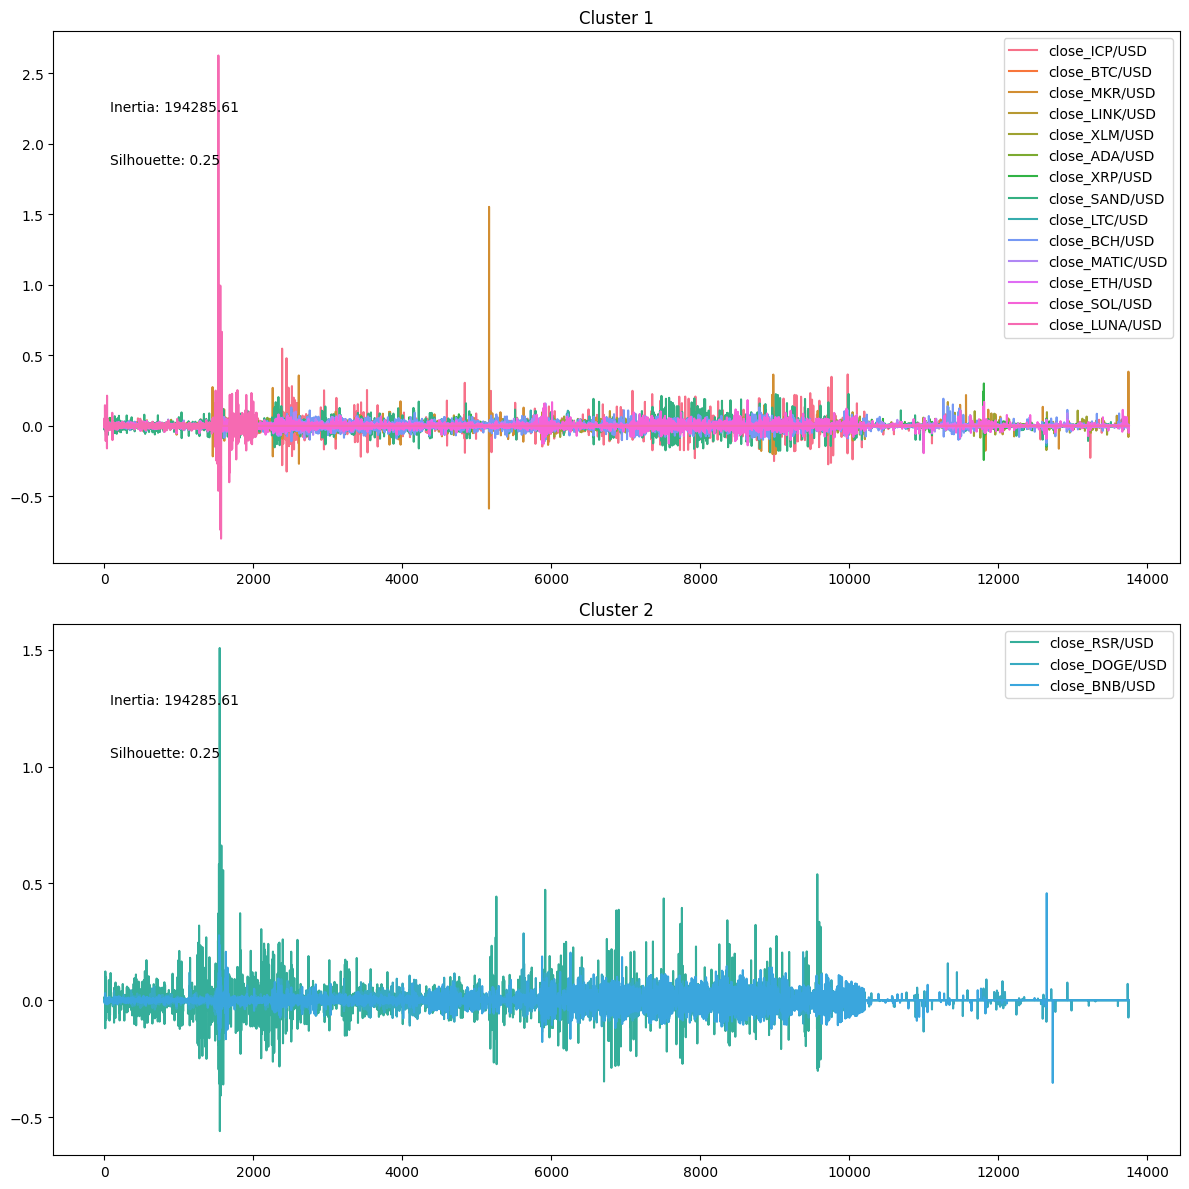

Running experiment for 3 clusters...
K-Means clustering completed.
Clustering results logged to MLflow.
Silhouette Score: 0.23002526104684443
Inertia Score: 144002.3627834384


/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster visualization plot saved and logged to MLflow.


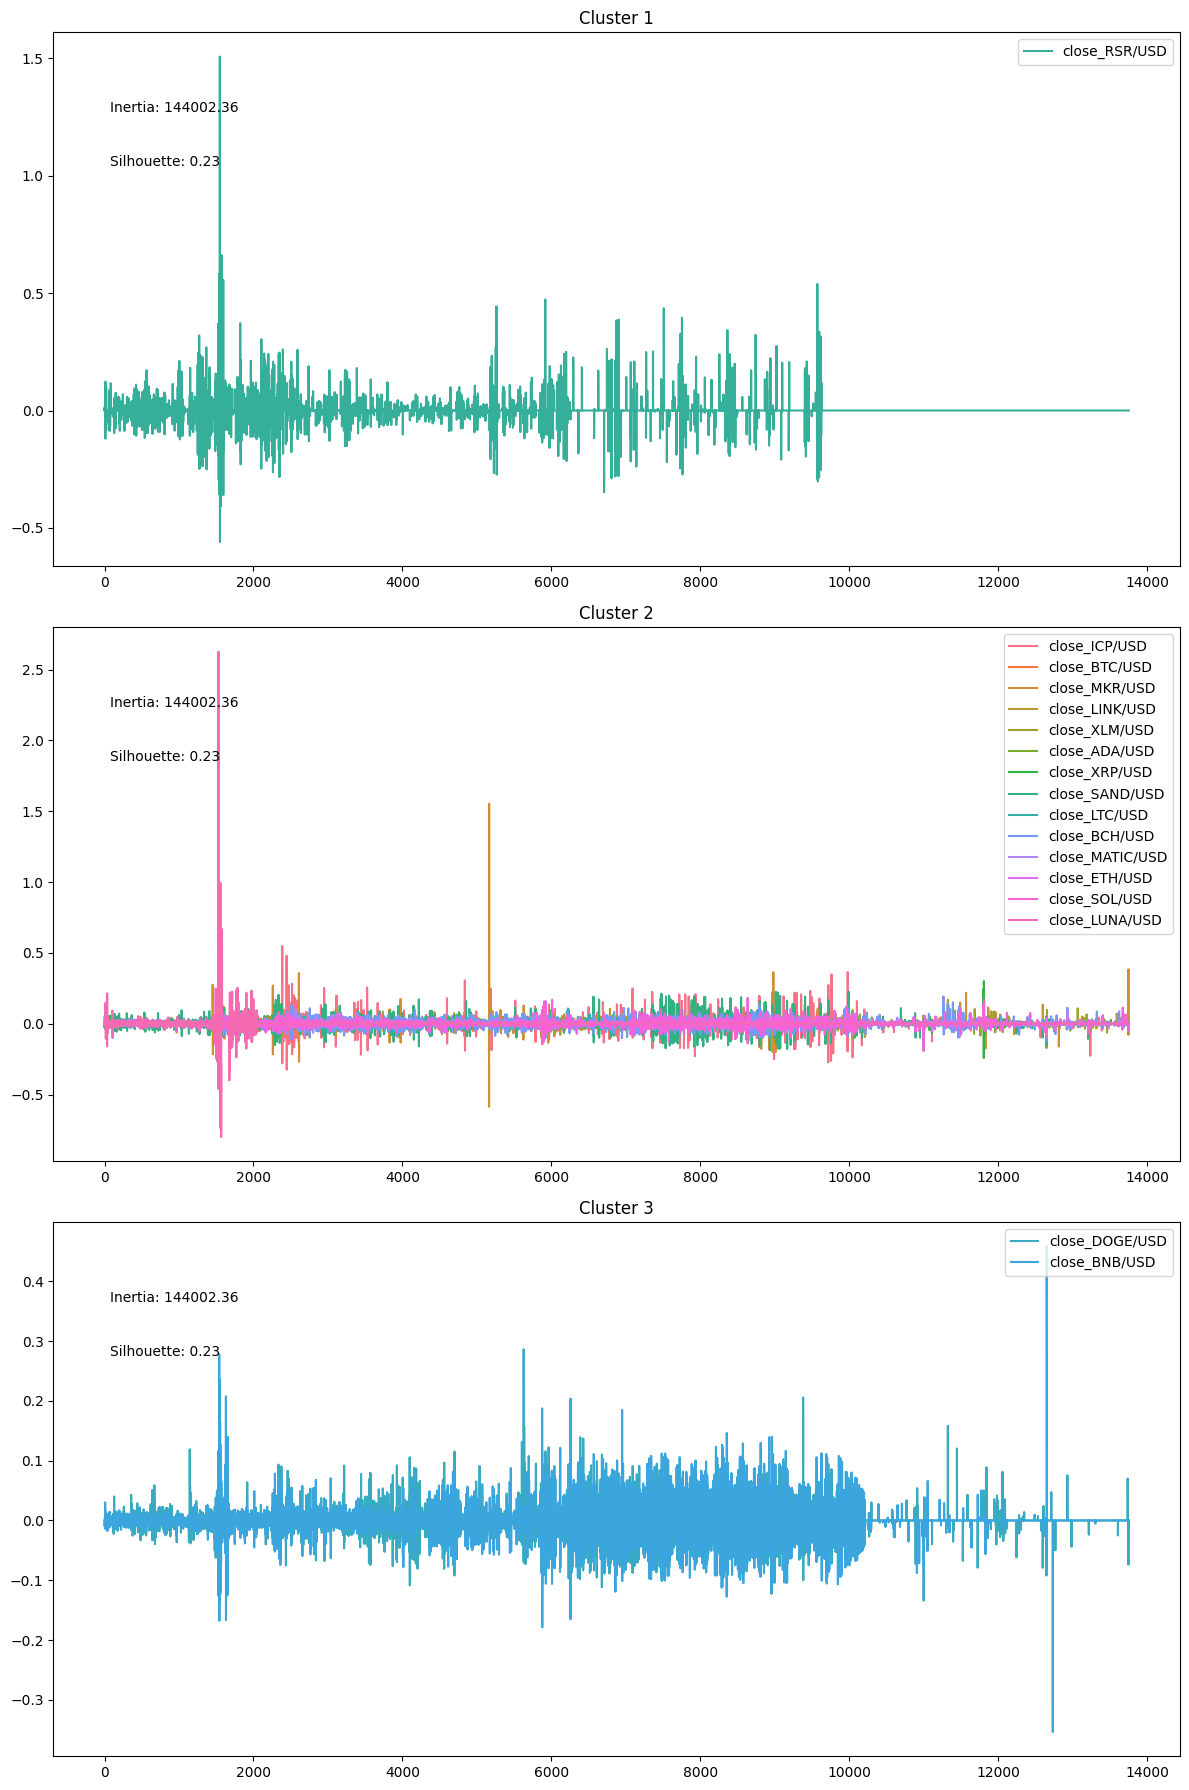

Running experiment for 4 clusters...
K-Means clustering completed.
Clustering results logged to MLflow.
Silhouette Score: 0.12403553206036054
Inertia Score: 108202.70628862115


/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster visualization plot saved and logged to MLflow.


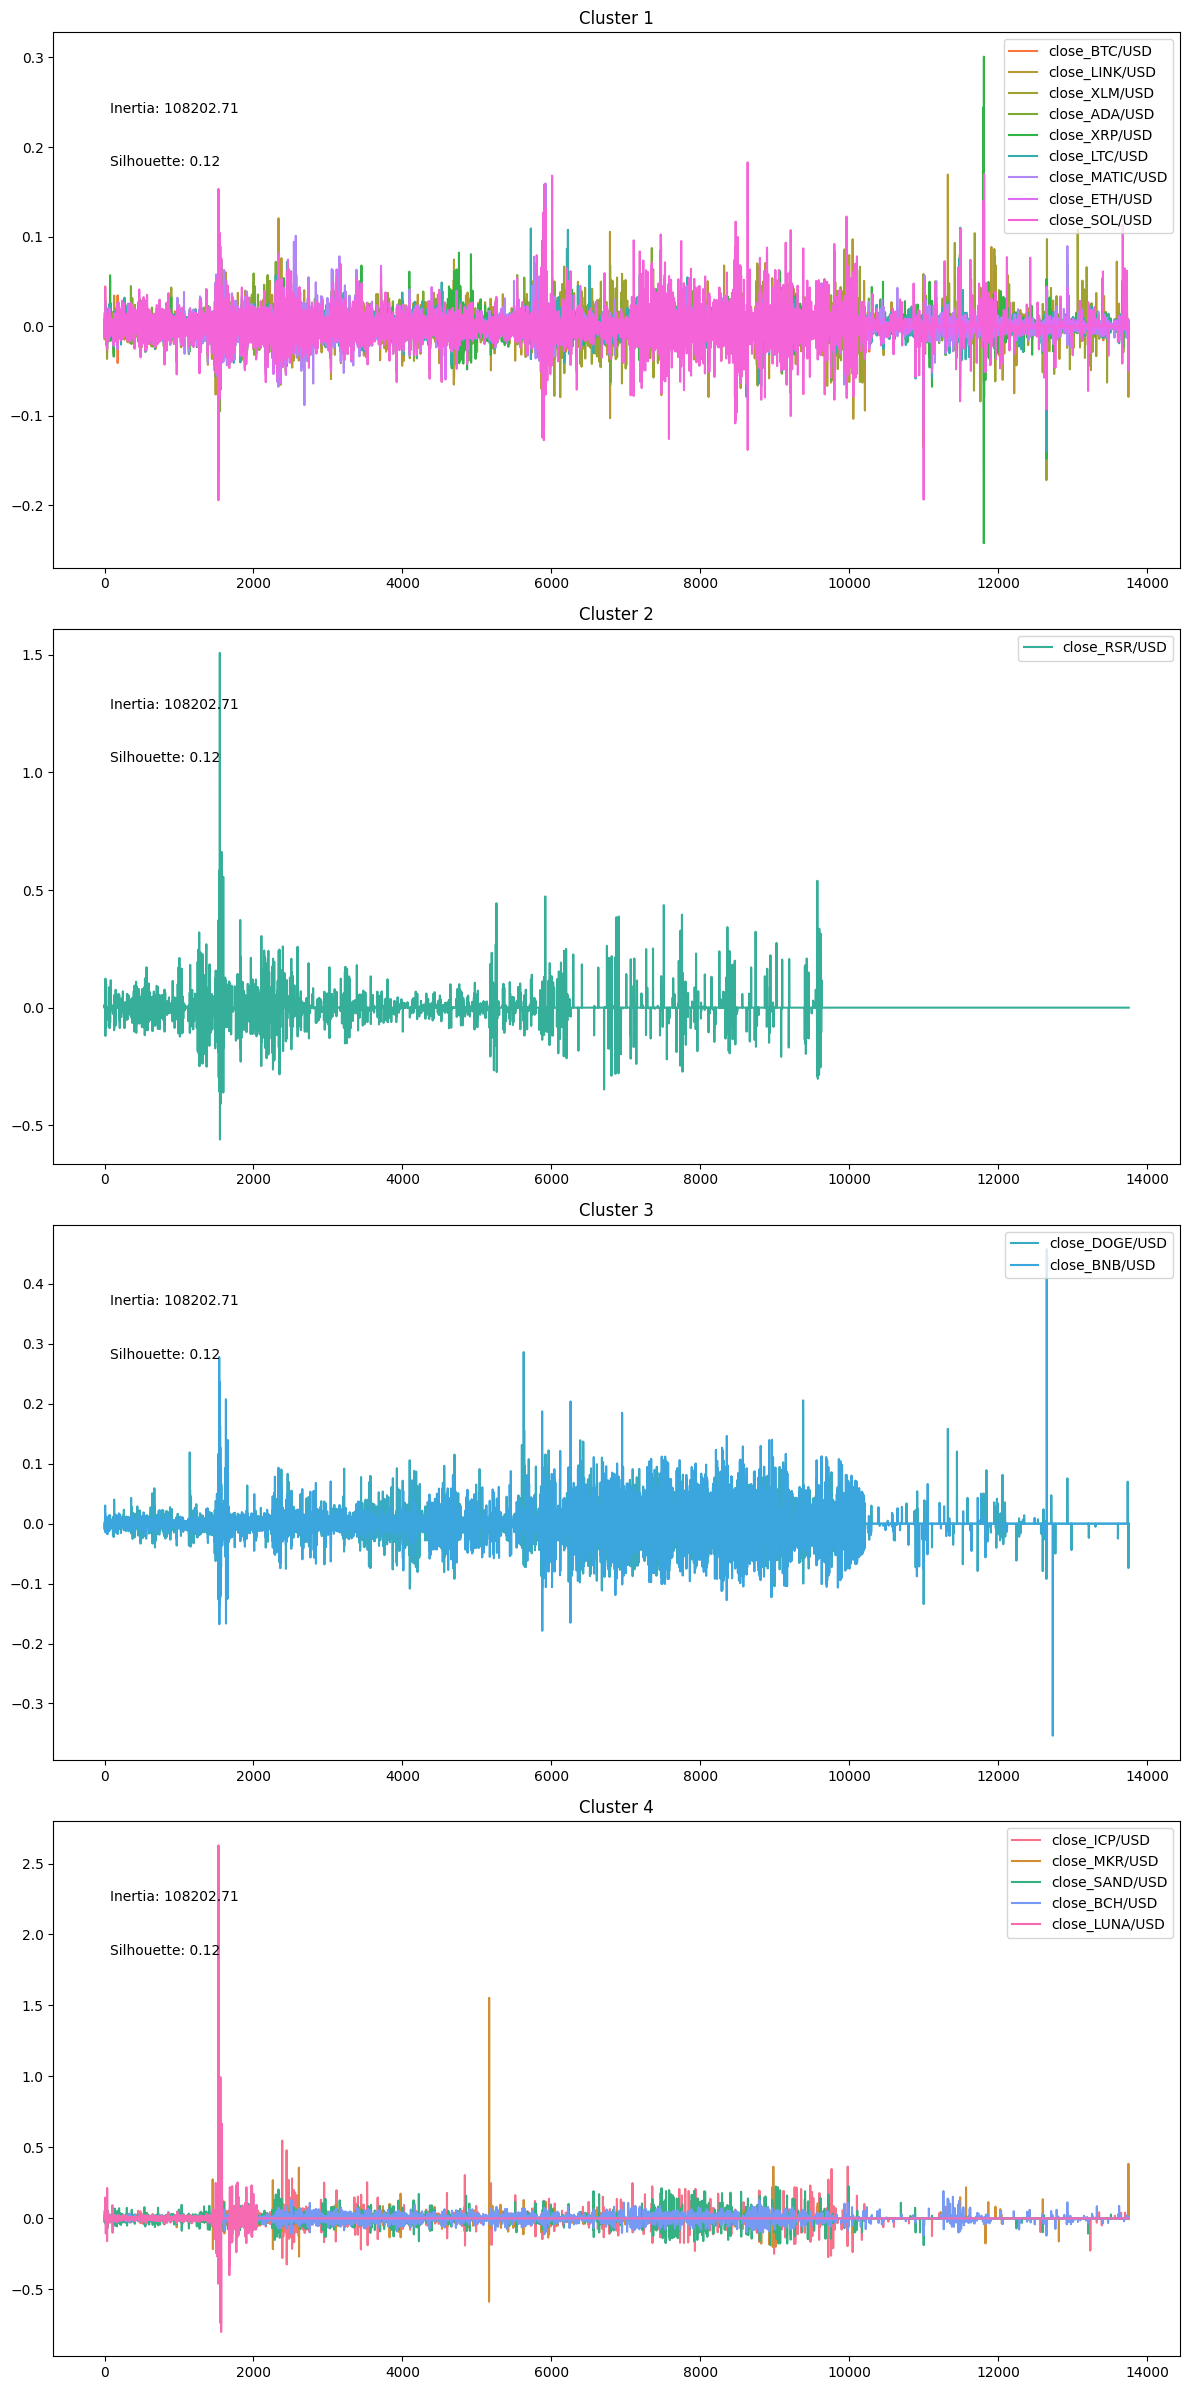

Running experiment for 5 clusters...
K-Means clustering completed.
Clustering results logged to MLflow.
Silhouette Score: 0.13445428866369197
Inertia Score: 91314.36380730479


/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster visualization plot saved and logged to MLflow.


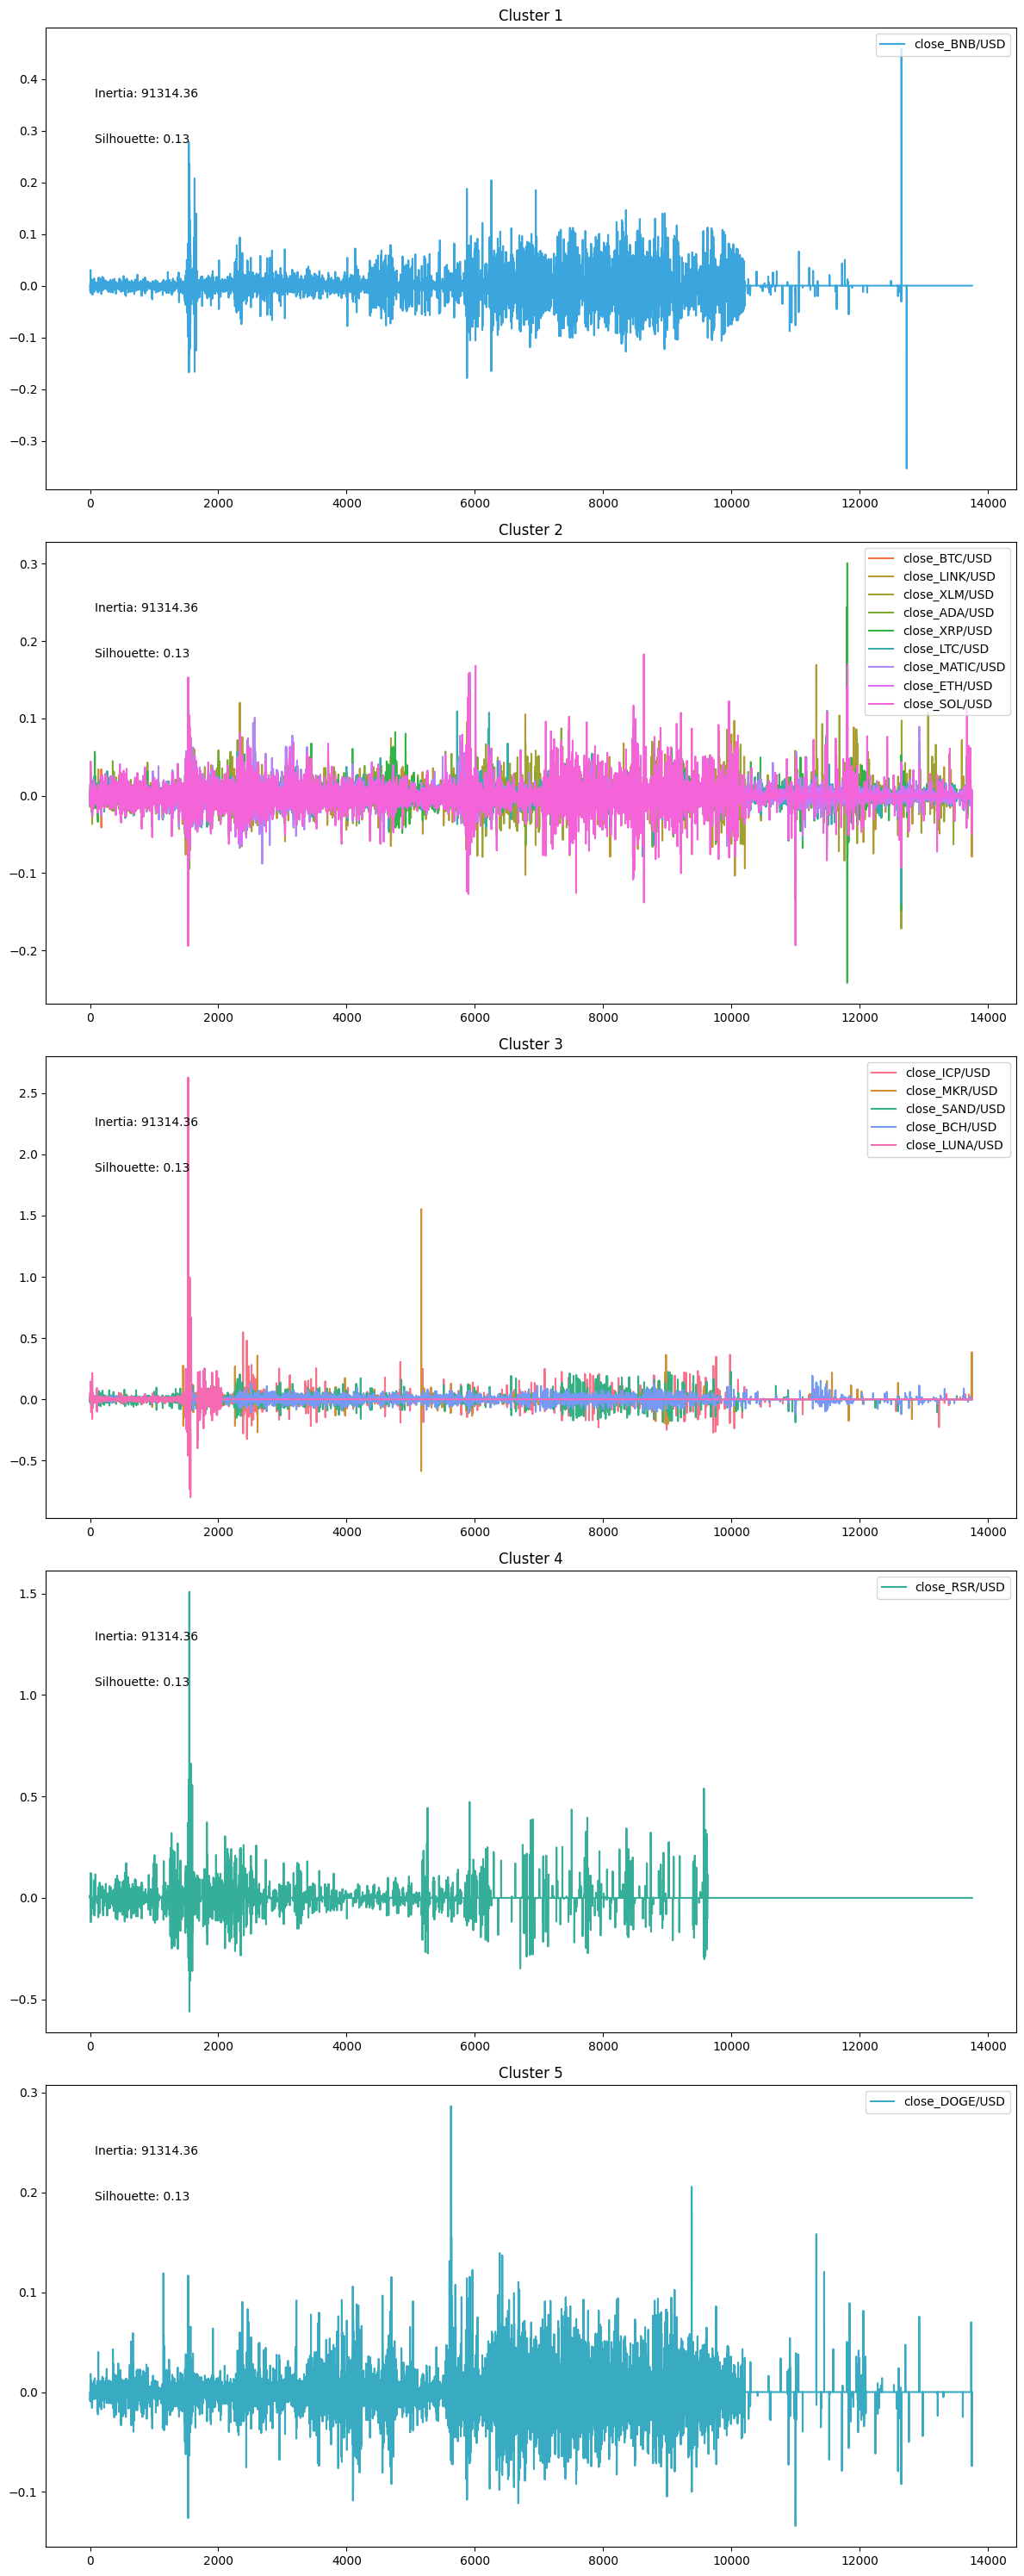

Running experiment for 6 clusters...
K-Means clustering completed.
Clustering results logged to MLflow.
Silhouette Score: 0.031097030219482187
Inertia Score: 80482.44141658526


/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster visualization plot saved and logged to MLflow.


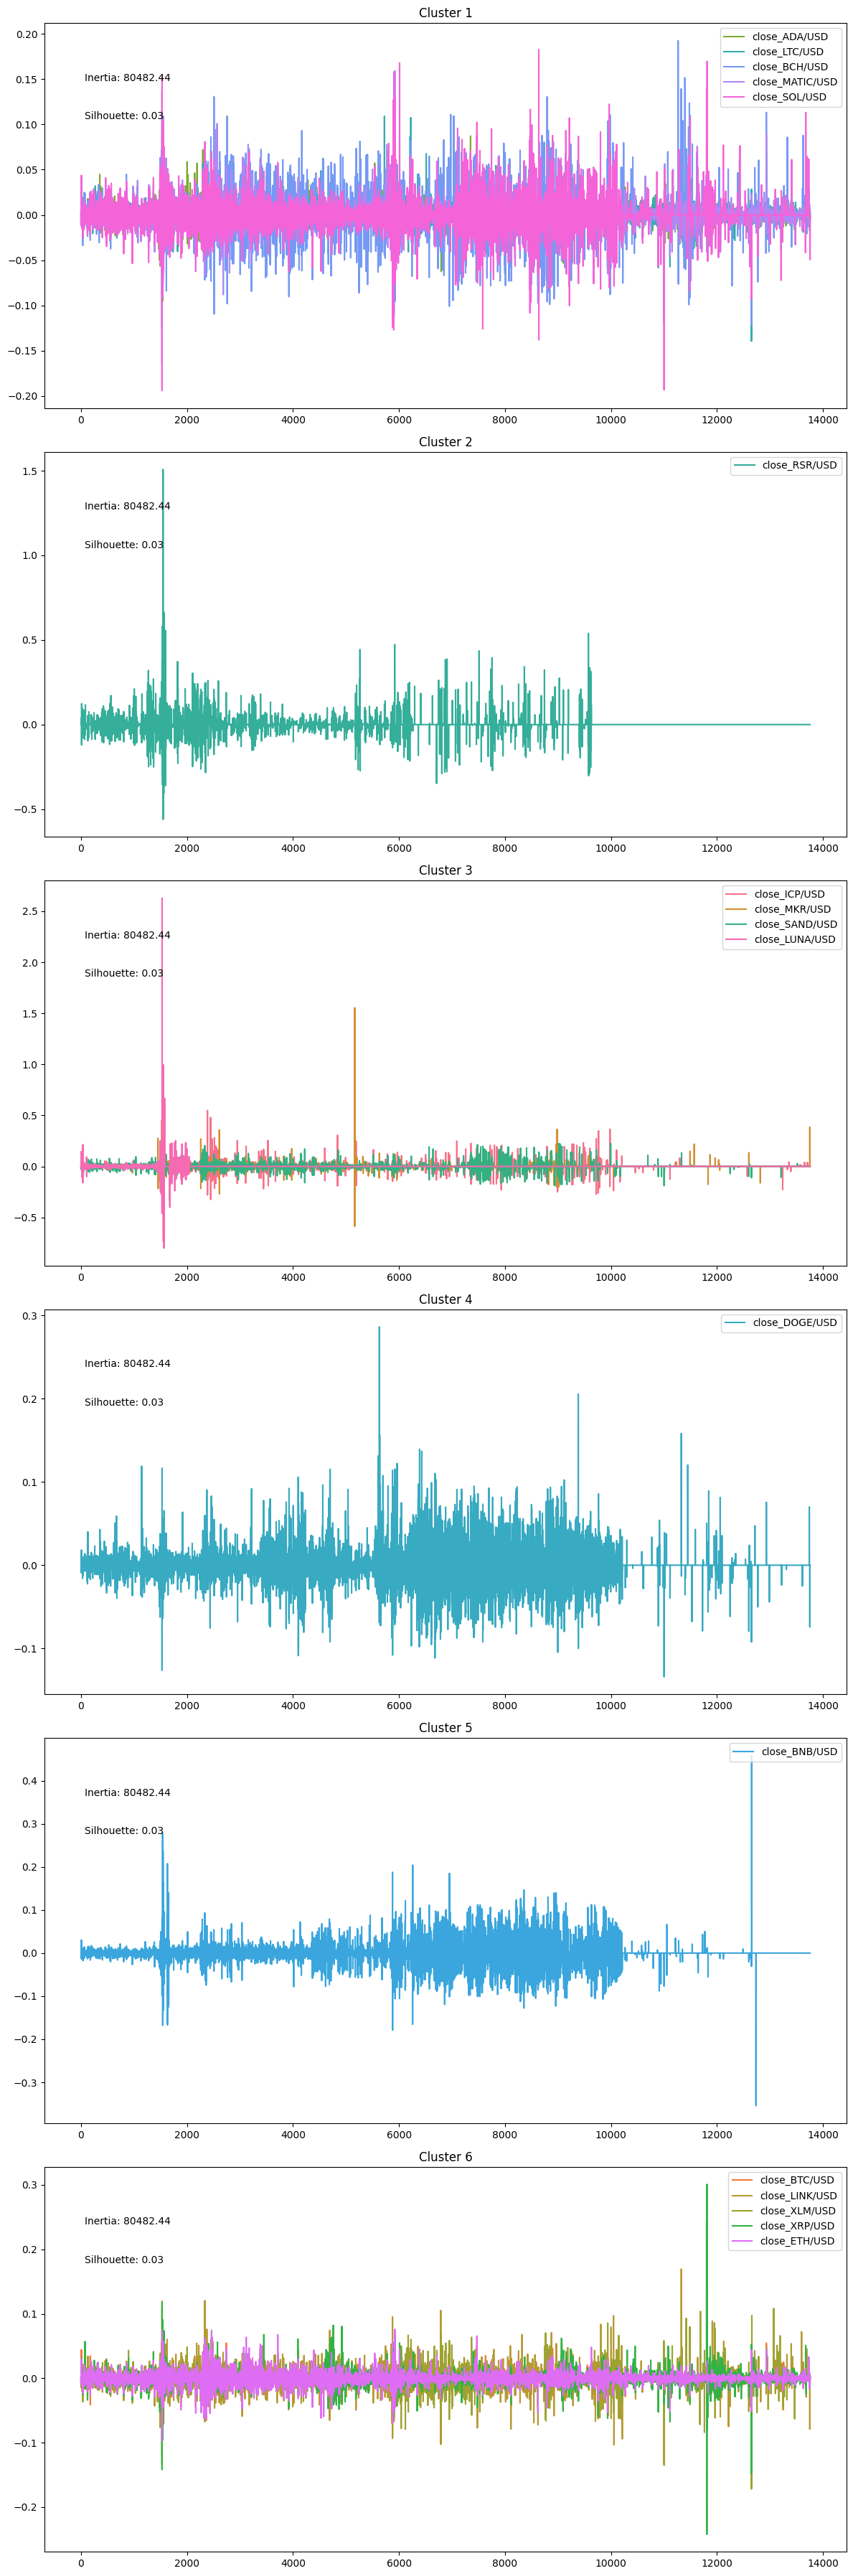

Running experiment for 7 clusters...
K-Means clustering completed.
Clustering results logged to MLflow.
Silhouette Score: 0.05727302190496405
Inertia Score: 67153.22479832405


/home/gianfranco/Desktop/uni/price-oracle/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster visualization plot saved and logged to MLflow.


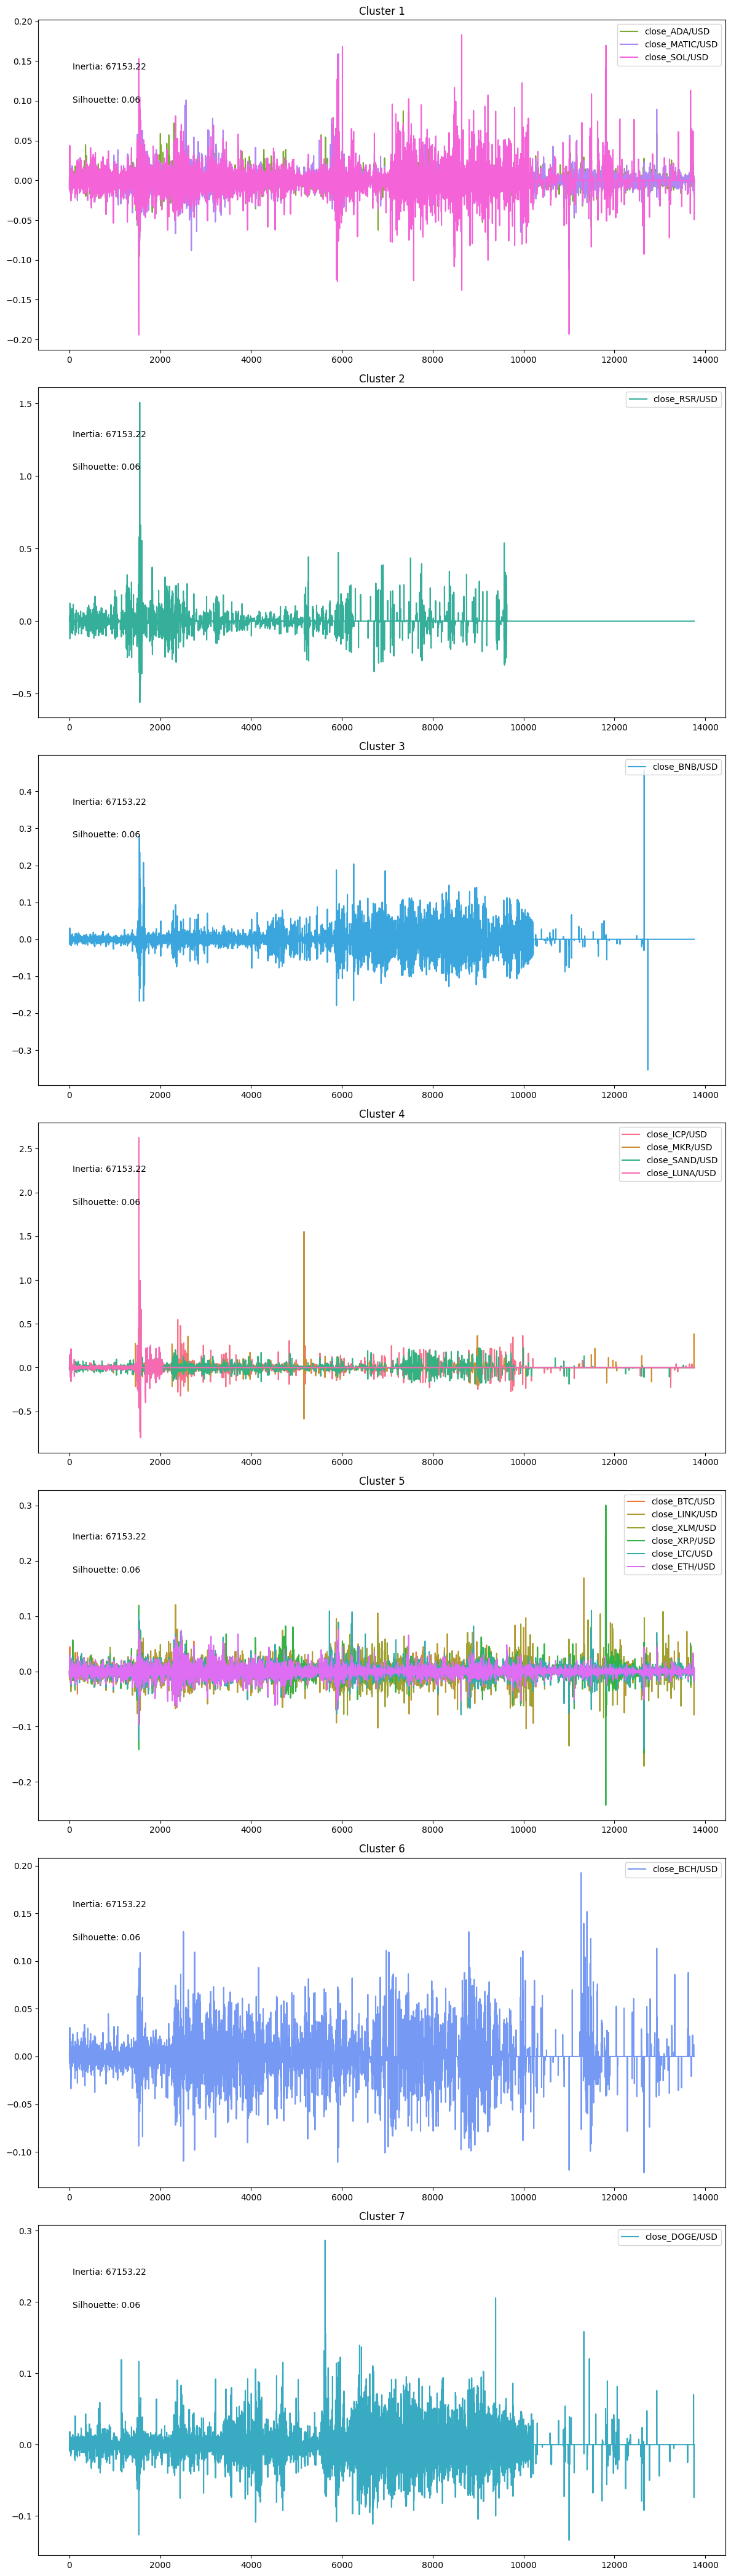

Calculating DTW Distances: 100%|██████████| 17/17 [02:55<00:00, 10.32s/it]


DTW distances calculated.
Running experiment for 2 clusters...
K-Medoids clustering completed.
Clustering results logged to MLflow.
Silhouette Score: -0.045914629151919184
Inertia Score: 1189.9789327587691
Cluster visualization plot saved and logged to MLflow.


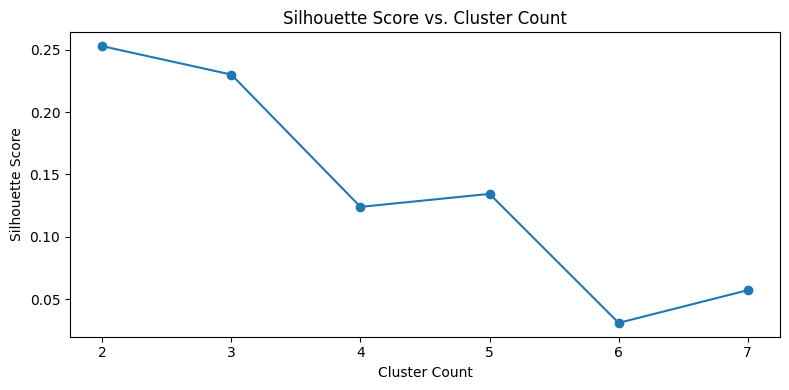

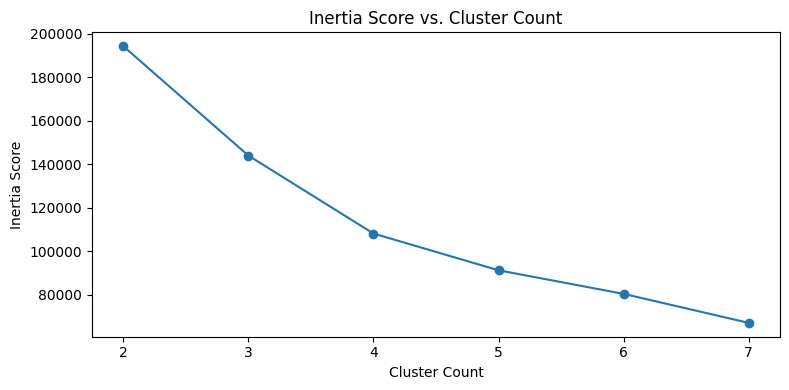

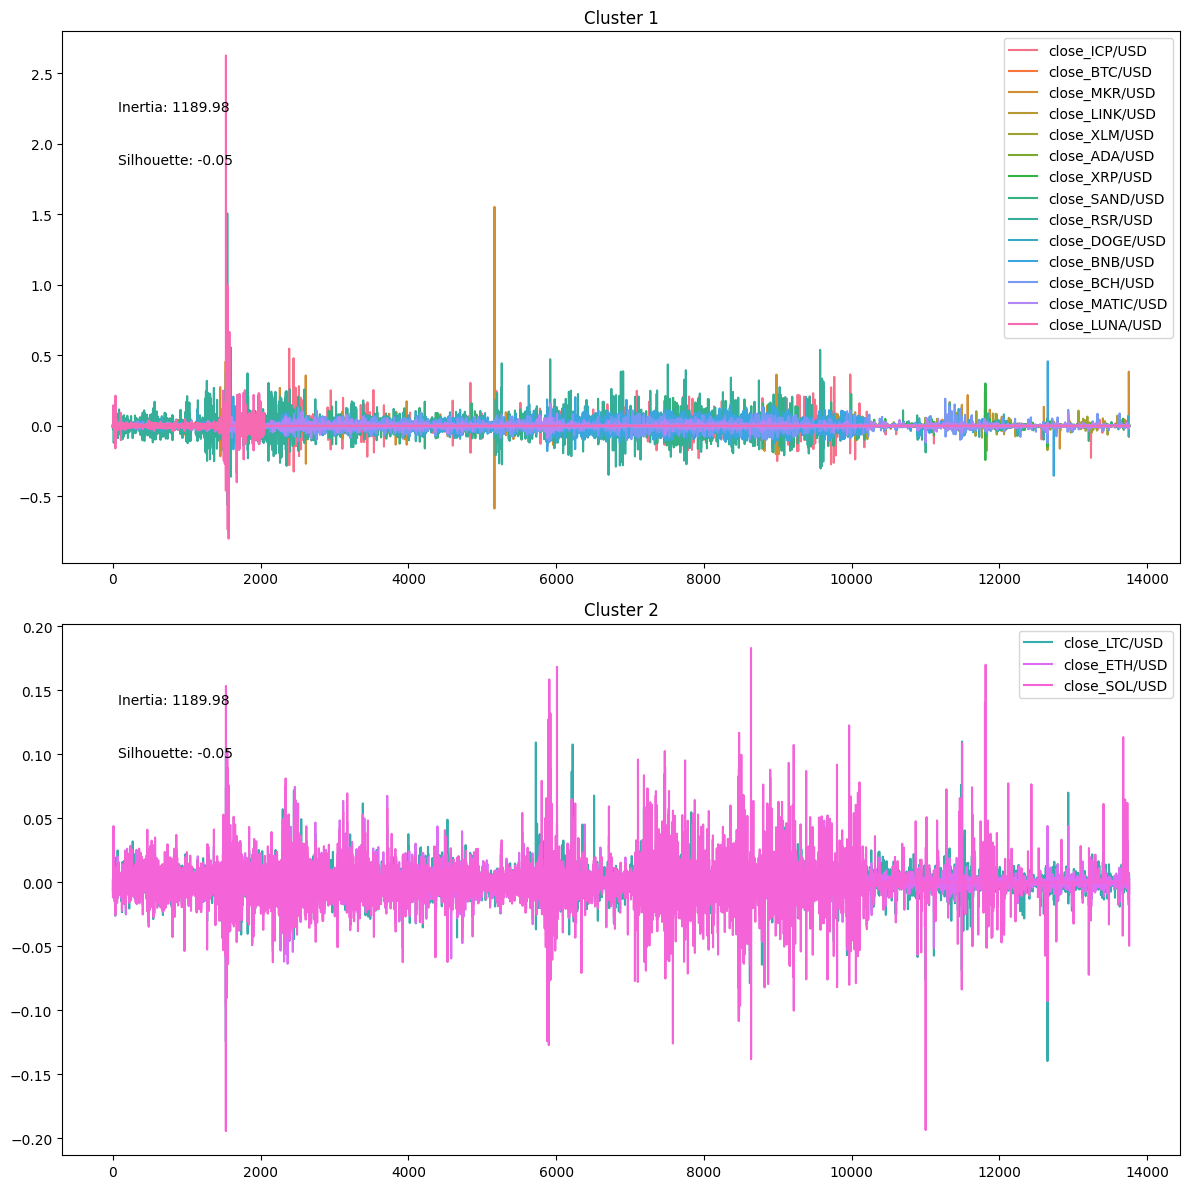

Running experiment for 3 clusters...
K-Medoids clustering completed.
Clustering results logged to MLflow.
Silhouette Score: -0.03891897022244814
Inertia Score: 1095.7437168335373
Cluster visualization plot saved and logged to MLflow.


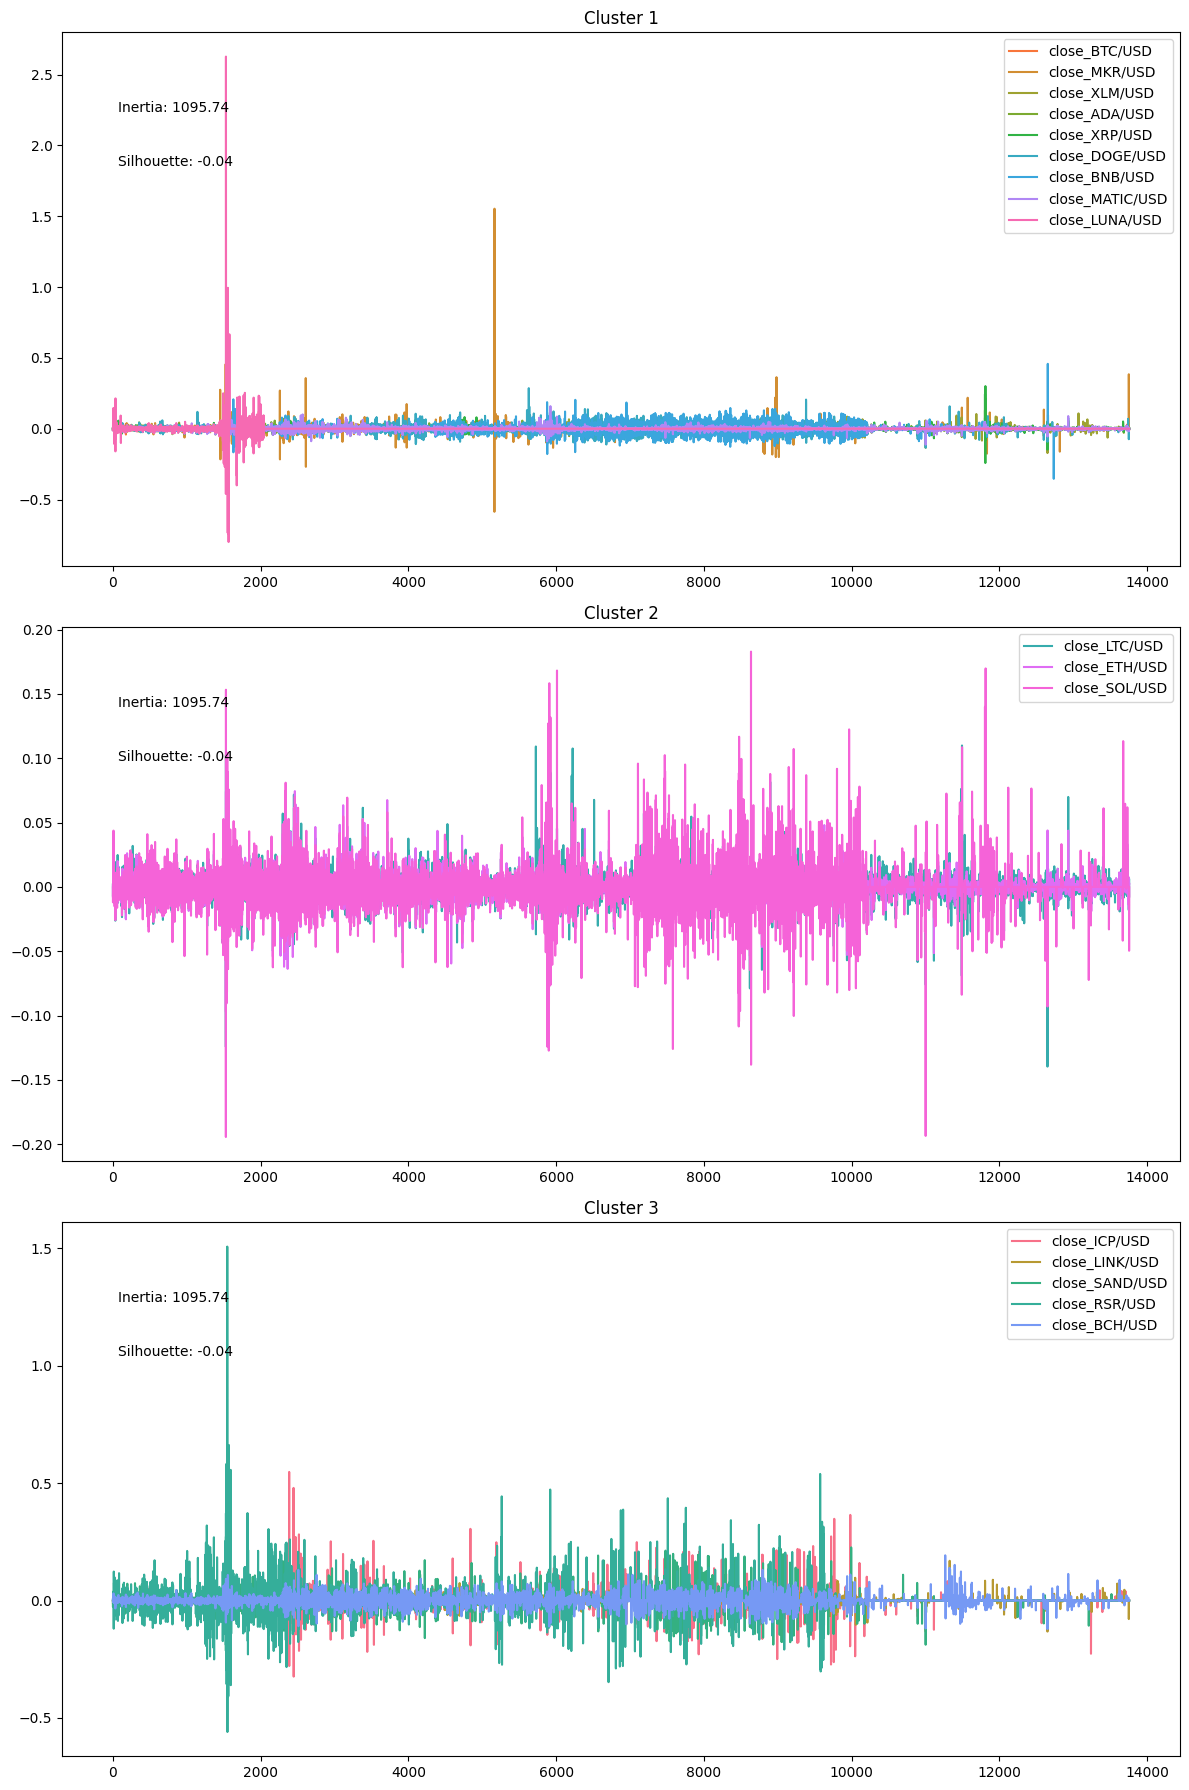

Running experiment for 4 clusters...
K-Medoids clustering completed.
Clustering results logged to MLflow.
Silhouette Score: -0.10320785926361854
Inertia Score: 1037.6519600837896
Cluster visualization plot saved and logged to MLflow.


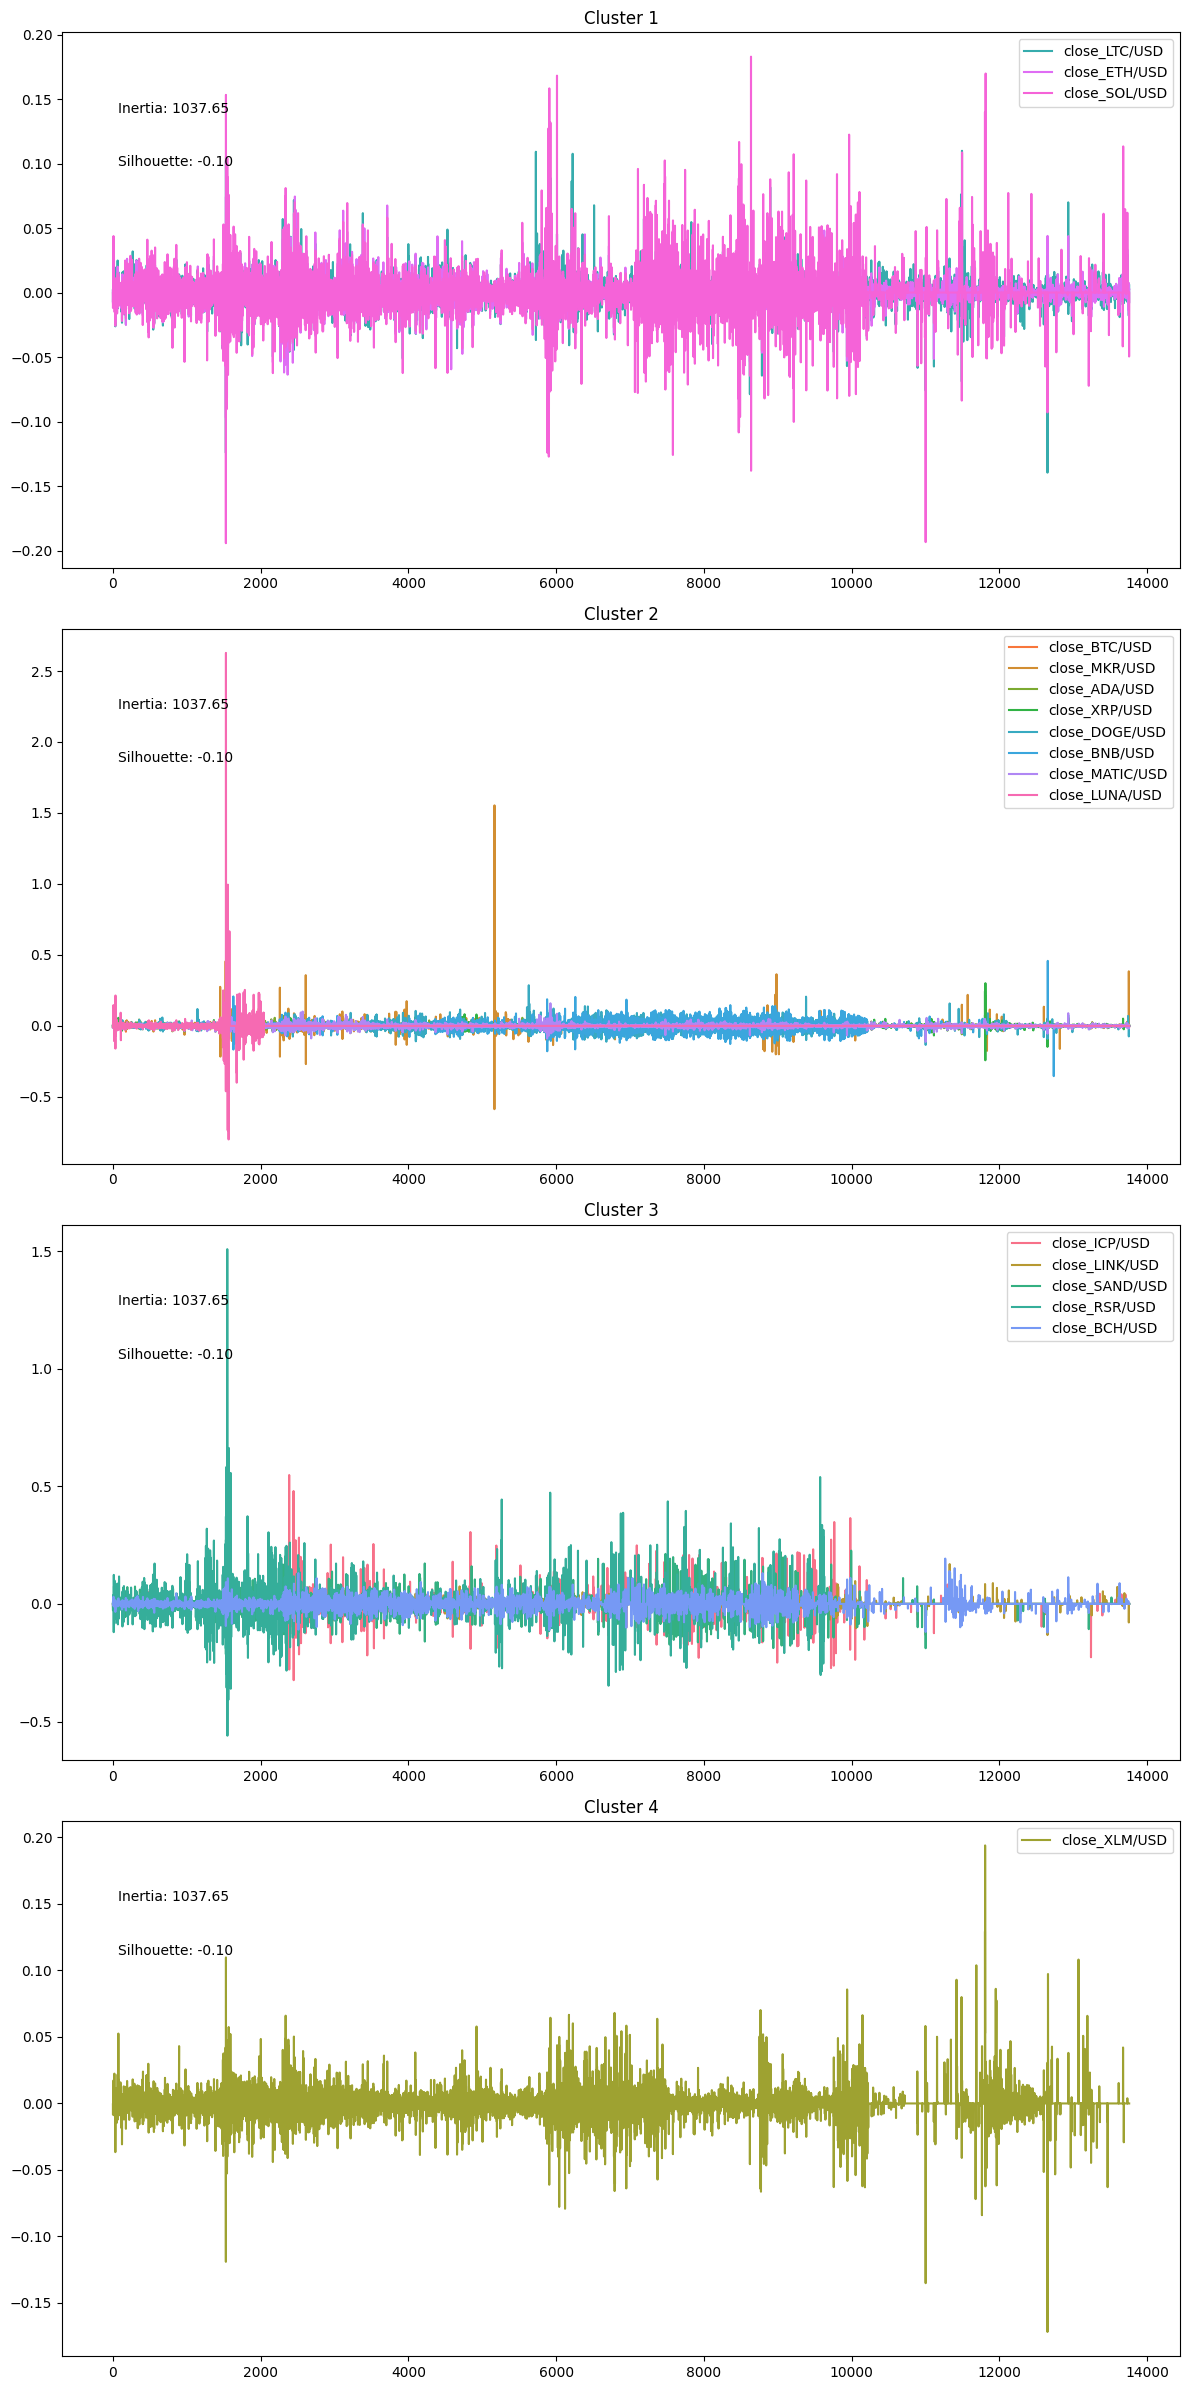

Running experiment for 5 clusters...
K-Medoids clustering completed.
Clustering results logged to MLflow.
Silhouette Score: -0.08891097904986388
Inertia Score: 955.7703124545253
Cluster visualization plot saved and logged to MLflow.


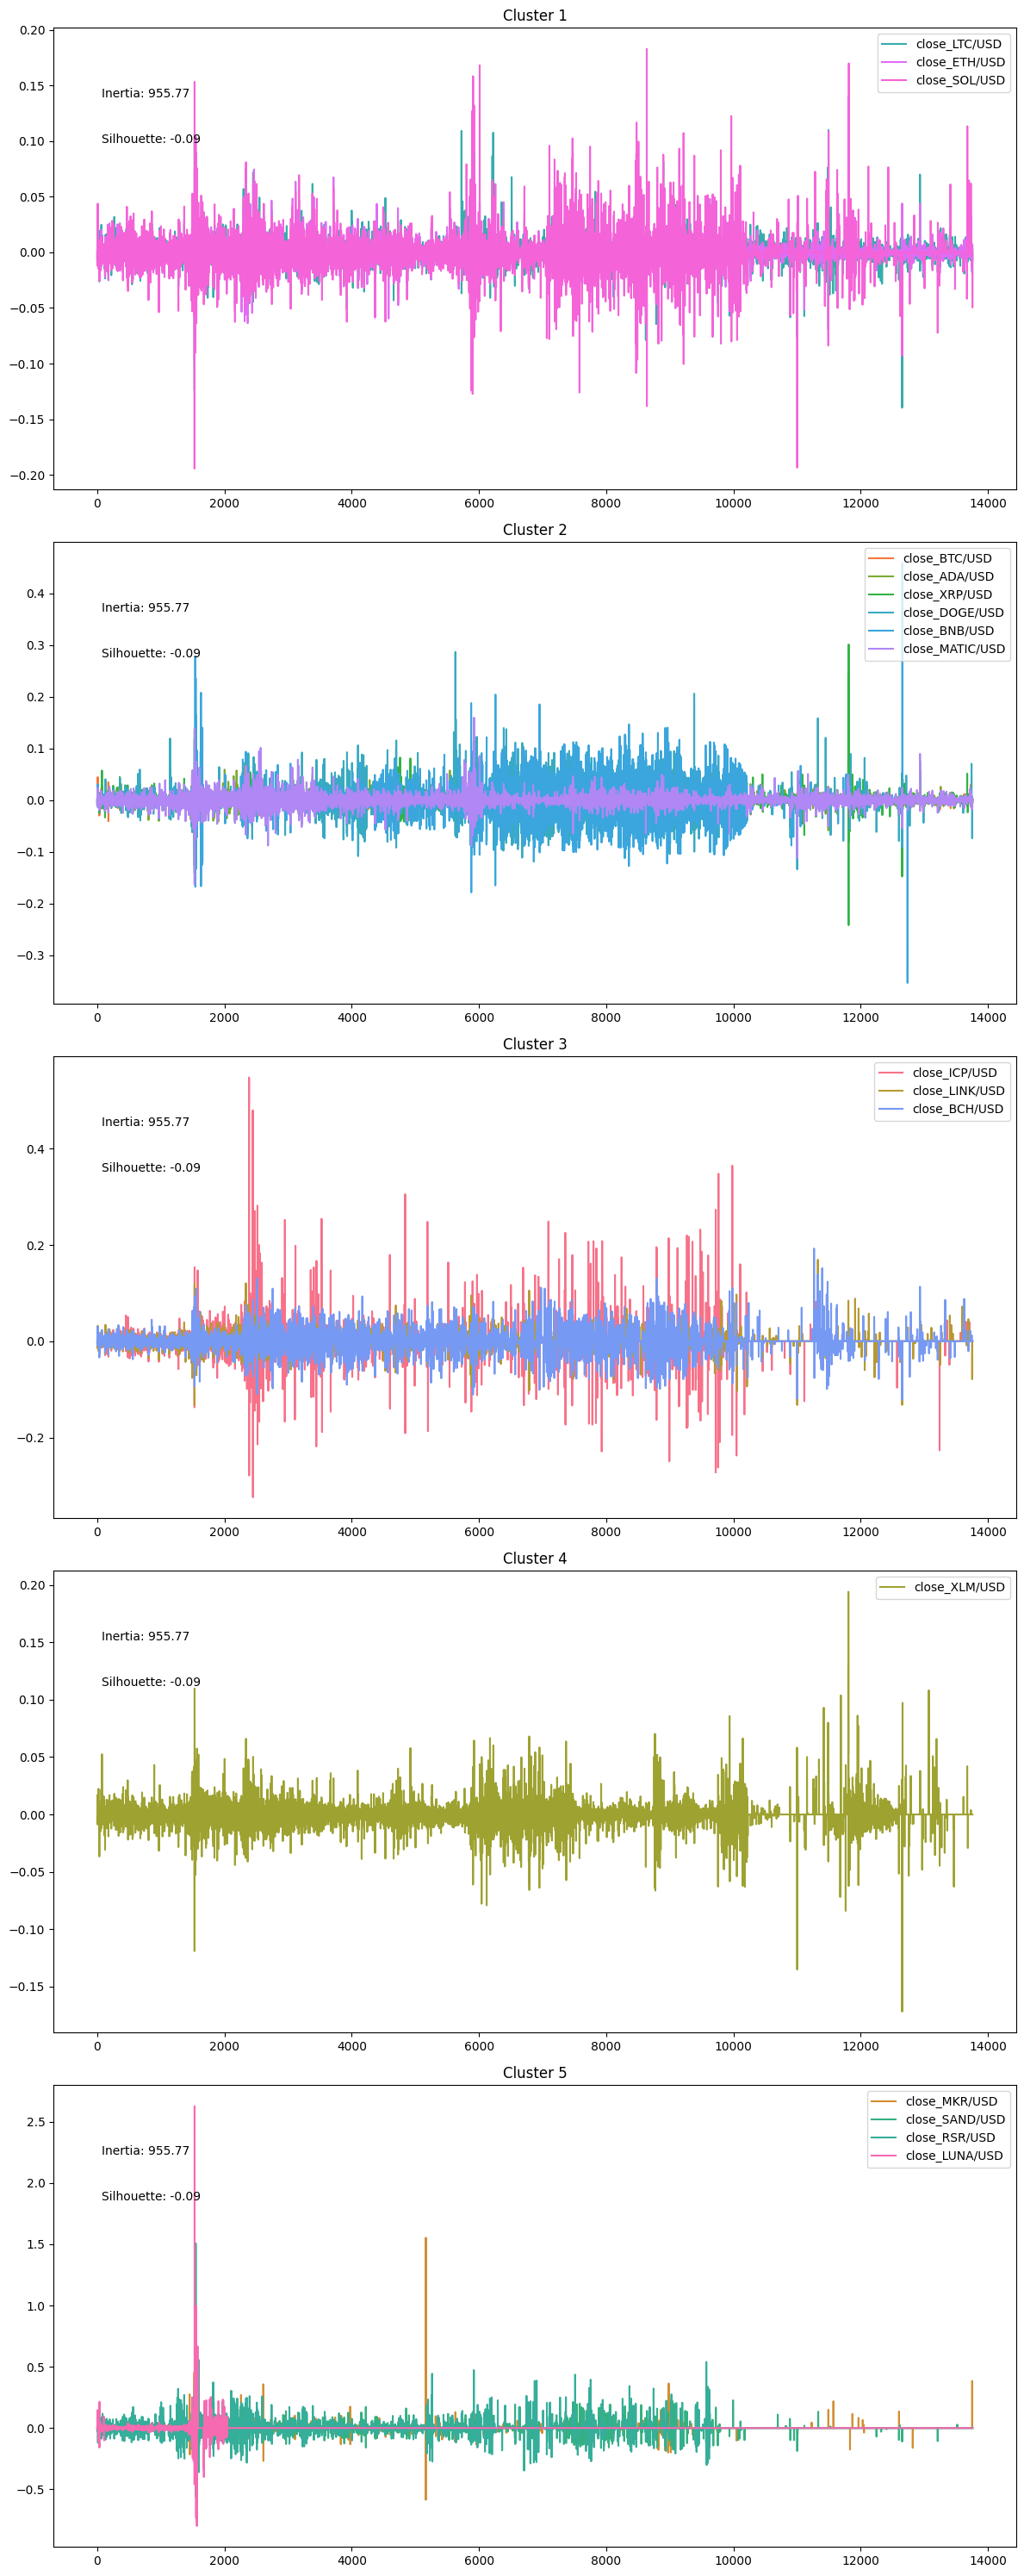

Running experiment for 6 clusters...
K-Medoids clustering completed.
Clustering results logged to MLflow.
Silhouette Score: -0.07335035854009841
Inertia Score: 895.5039342813735
Cluster visualization plot saved and logged to MLflow.


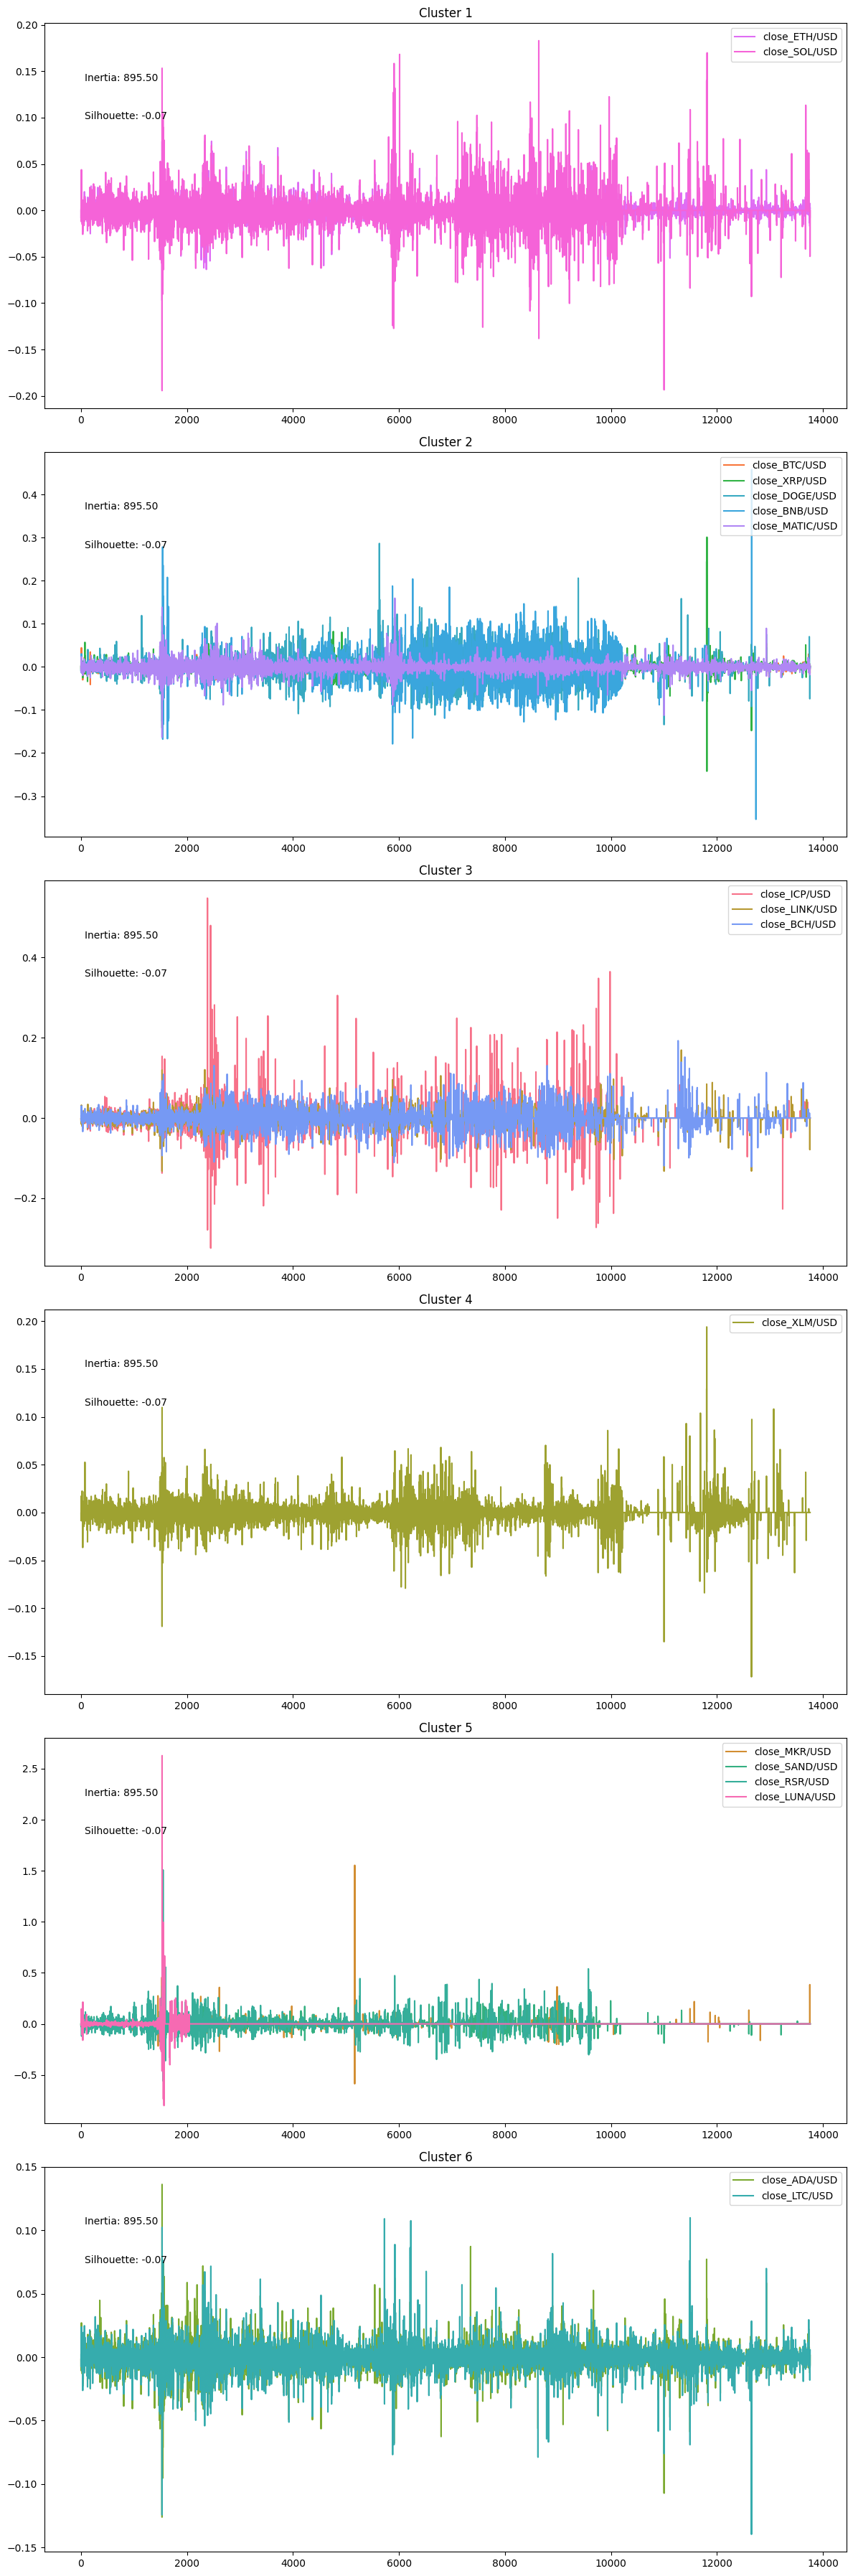

Running experiment for 7 clusters...
K-Medoids clustering completed.
Clustering results logged to MLflow.
Silhouette Score: -0.0988968524325738
Inertia Score: 835.8670819181829
Cluster visualization plot saved and logged to MLflow.


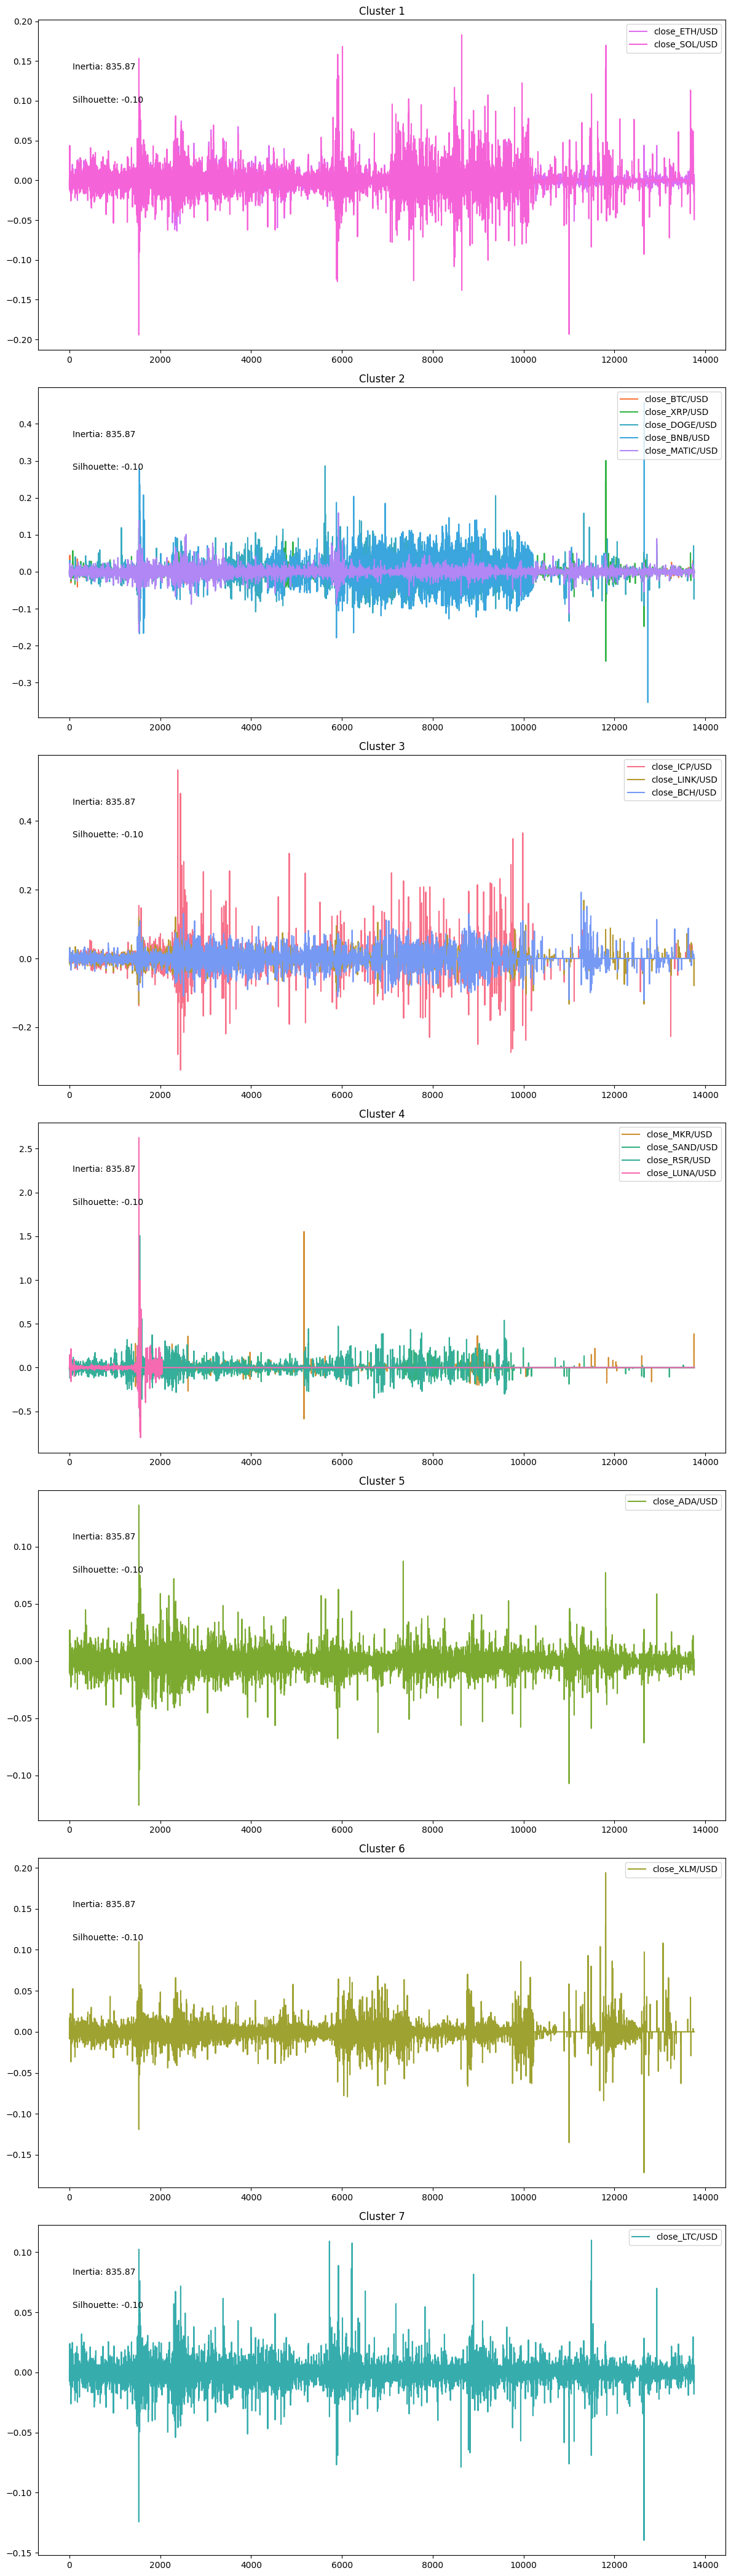

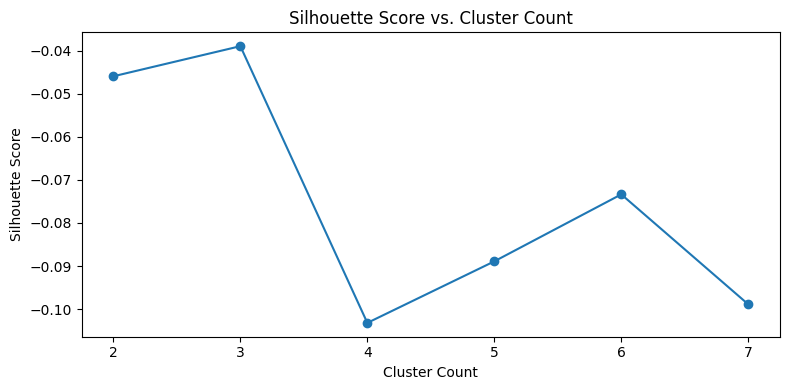

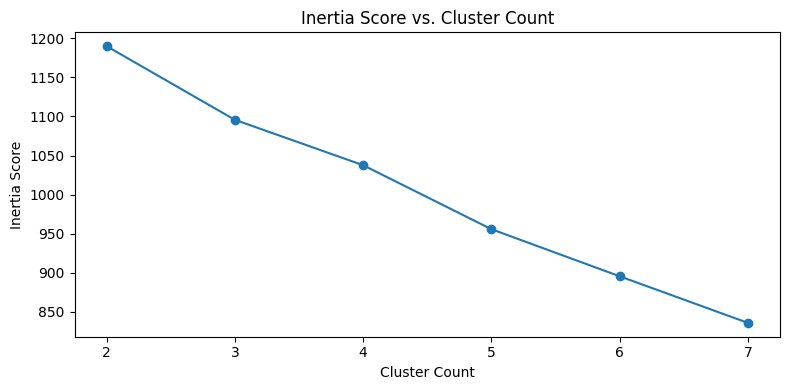

In [7]:
# Select the time series columns for clustering
time_series_data = merged_df.iloc[:, 1:].pct_change().dropna().values  # Exclude the 'date' column

# plot time_series_data
# set y axis in range -0.7, 0.7, subplots
# time_series_data.plot(subplots=True, ylim=(-0.7, 0.7), figsize=(20, 20))

# Transpose the data to have time series in rows and measurements in columns
time_series_data = time_series_data.T

# for i in tqdm(range(time_series_data.shape[0]), desc="Calculating DTW Distances"):
#     for j in range(i, time_series_data.shape[0]):
#         distance, _ = time_series_data[i], time_series_data[j]


do_clustering(time_series_data, experiment_name_suffix="cropped_scaled_pruned_log_scaling", clustering_algorithm="KMeans")
do_clustering(time_series_data, experiment_name_suffix="cropped_scaled_pruned_log_scaling", clustering_algorithm="KMedoids")